In [1]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

tf.config.list_physical_devices('GPU')
print("✅ Entorno limpio y funcionando")

✅ Entorno limpio y funcionando


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/323M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Etiqueta: 0 | Imagen shape: (256, 256, 3)


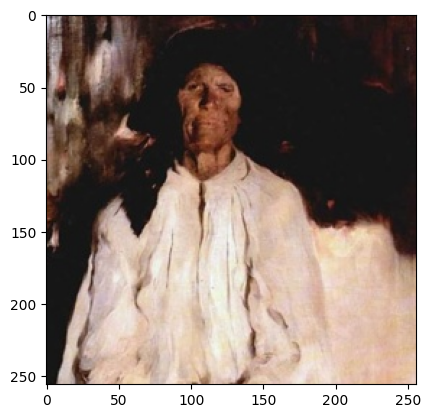

In [2]:
#Se carga el dataset desde HuggingFace
dataset = load_dataset("zguo0525/ArtBench")

#Se obtienen las divisiones
train_ds = dataset["train"]
test_ds = dataset["test"]

#Ejemplo
ej = train_ds[100]
img_array = np.array(ej["image"])
print("Etiqueta:", ej["label"], "| Imagen shape:", img_array.shape)
plt.imshow(img_array)
plt.show()

In [40]:
IMG_SIZE = 96

def preprocess_tf(example):
    #Se realiza la siguiente conversión: PIL -> NumPy -> Tensor
    image = np.array(example["image"])
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) #Redimensión
    image = tf.cast(image, tf.float32) / 255.0   # normalización [0,1]
    label = example["label"]
    return {"image": image, "label": label}

#Se aplica una transformación eficiente sin cargar todo a memoria
#Para que colab no explote c:
train_tf = dataset["train"].with_transform(preprocess_tf)
test_tf  = dataset["test"].with_transform(preprocess_tf)

tf_train = train_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    shuffle=True,
    drop_remainder=True
)

tf_test = test_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    drop_remainder=True
)

#Se crean los nuevos datasets para Keras
tf_train_ae = train_tf.to_tf_dataset(
    columns="image",
    label_cols=None,
    batch_size=64,
    shuffle=True
).map(lambda x: (x, x))

tf_test_ae = test_tf.to_tf_dataset(
    columns="image",
    label_cols=None,
    batch_size=64
).map(lambda x: (x, x))

In [10]:
tf.keras.backend.clear_session()
latent_dim = 256
IMG_SIZE = 96

def fast_autoencoder(img_size=64):
    inp = layers.Input((img_size, img_size, 3))

    # -------- ENCODER ----------
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(inp)
    x = layers.MaxPool2D(2)(x)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D(2)(x)

    shape_before = tf.keras.backend.int_shape(x)

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim)(x)

    # -------- DECODER ----------
    x = layers.Dense(shape_before[1]*shape_before[2]*shape_before[3], activation="relu")(latent)
    x = layers.Reshape((shape_before[1], shape_before[2], shape_before[3]))(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D()(x)
    out = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

    ae = models.Model(inp, out)
    enc = models.Model(inp, latent)
    return ae, enc

autoencoder, encoder = fast_autoencoder(IMG_SIZE)

In [11]:
import tensorflow as tf
import tensorflow.image as tfi
import keras.backend as K
def ssim_metric(y_true, y_pred):
    # SSIM devuelve valores por imagen, así que promediamos
    return tf.reduce_mean(tfi.ssim(y_true, y_pred, max_val=1.0))


autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mae",                   # tu loss principal
    metrics=[
        tf.keras.metrics.MeanSquaredError(name="mse"),
        ssim_metric                # métrica personalizada
    ]
)


history = autoencoder.fit(
    tf_train_ae,
    validation_data=tf_test_ae,
    epochs=20,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=6,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 148ms/step - loss: 0.1570 - mse: 0.0415 - ssim_metric: 0.2580 - val_loss: 0.0974 - val_mse: 0.0190 - val_ssim_metric: 0.3253 - learning_rate: 1.0000e-04
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 140ms/step - loss: 0.0943 - mse: 0.0180 - ssim_metric: 0.3355 - val_loss: 0.0882 - val_mse: 0.0161 - val_ssim_metric: 0.3581 - learning_rate: 1.0000e-04
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 139ms/step - loss: 0.0862 - mse: 0.0156 - ssim_metric: 0.3650 - val_loss: 0.0834 - val_mse: 0.0147 - val_ssim_metric: 0.3764 - learning_rate: 1.0000e-04
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 139ms/step - loss: 0.0817 - mse: 0.0144 - ssim_metric: 0.3817 - val_loss: 0.0802 - val_mse: 0.0138 - val_ssim_metric: 0.3894 - learning_rate: 1.0000e-04
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 139ms/step - loss: 0.0789 - mse: 0.0136 - ssim_metric: 0.3934 - val_loss: 0.0775 - val_mse: 0.0132 - val_ssim_metric: 0.3996 - learning_rate: 1.0000e-04
Epoch 6/20

In [47]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9216)           │     2,368,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,423,723 (55.02 MB)

 Trainable params: 4,807,907 (18.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,615,816 (36.68 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


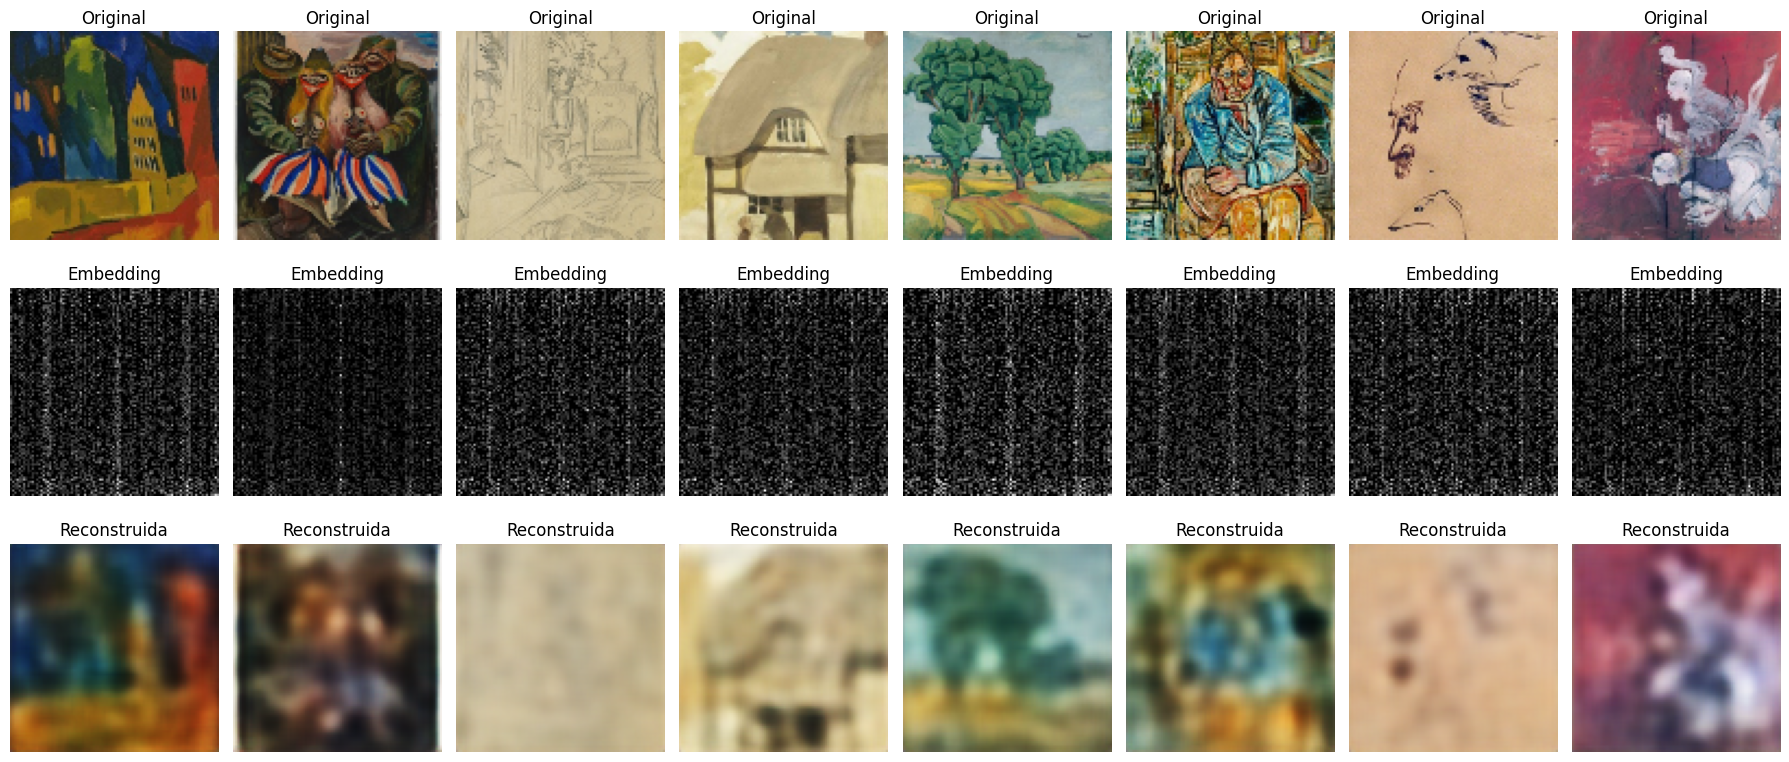

In [51]:
encoder_fixed = tf.keras.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.layers[9].output   # capa Dense (256)
)

for batch, _ in tf_test_ae.take(1):
    originals = batch.numpy()
    recons = autoencoder.predict(originals[:8])
    embeds = encoder_fixed.predict(originals[:8])

N = 8
latent_dim = embeds.shape[1]
side = int(np.sqrt(latent_dim))   # 16 si latent_dim = 256

plt.figure(figsize=(18, 8))

for i in range(N):
    # Original
    plt.subplot(3, N, i+1)
    plt.imshow(originals[i])
    plt.title("Original")
    plt.axis("off")

    # Embedding como imagen
    emb_img = embeds[i].reshape(side, side)
    plt.subplot(3, N, i+1+N)
    plt.imshow(emb_img, cmap='gray')
    plt.title("Embedding")
    plt.axis("off")

    # Reconstrucción
    plt.subplot(3, N, i+1+2*N)
    plt.imshow(recons[i])
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
import numpy as np

def extract_embeddings(encoder, tf_dataset):
    embeddings = []
    labels = []

    for batch_imgs, batch_labels in tf_dataset:
        # Obtener embeddings
        z = encoder.predict(batch_imgs, verbose=0)
        embeddings.append(z)
        labels.append(batch_labels.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [35]:
raw_train = dataset["train"]
raw_test  = dataset["test"]

tf_train = raw_train.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    shuffle=True,
    drop_remainder=True
)

tf_test = raw_test.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    drop_remainder=True
)

def preprocess_tf(image, label):
    image = tf.image.resize(image, (96, 96))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

tf_train = tf_train.map(preprocess_tf)
tf_test  = tf_test.map(preprocess_tf)

def filter_empty(image, label):
    return tf.shape(image)[0] > 0

tf_train = tf_train.filter(filter_empty)
tf_test  = tf_test.filter(filter_empty)
tf_train = tf_train.prefetch(2)
tf_test  = tf_test.prefetch(2)

X_train_emb, y_train = extract_embeddings(encoder, tf_train)
X_test_emb,  y_test  = extract_embeddings(encoder, tf_test)

In [36]:
X_train_emb.shape, X_test_emb.shape

((49984, 256), (9984, 256))

In [62]:
from tensorflow.keras import models, layers, callbacks

mlp = models.Sequential([
    layers.Input(shape=(X_train_emb.shape[1],)),
    layers.Dense(256, activation='relu'),     # un poco más de capacidad
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64 , activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,           # si quieres que aprenda más antes de cortar
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = callbacks.ModelCheckpoint(
    "best_mlp_model.keras",
    monitor="val_loss",
    save_best_only=True
)

history = mlp.fit(
    X_train_emb, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2070 - loss: 2.1668 - val_accuracy: 0.2899 - val_loss: 1.9913 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2753 - loss: 1.9989 - val_accuracy: 0.3077 - val_loss: 1.9327 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2964 - loss: 1.9492 - val_accuracy: 0.3197 - val_loss: 1.8986 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3159 - loss: 1.9075 - val_accuracy: 0.3236 - val_loss: 1.8816 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3252 - loss: 1.8794 - val_accuracy: 0.3354 - val_loss: 1.8637 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3359 - loss: 1.8486 - val_accuracy: 0.3280 - val_loss: 1.8576 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3416 - loss: 1.

In [55]:
class_names = dataset["train"].features["label"].names
print(class_names)

['expressionism', 'art_nouveau', 'renaissance', 'ukiyo_e', 'realism', 'romanticism', 'surrealism', 'impressionism', 'baroque', 'post_impressionism']


In [63]:
import numpy as np

# Predicciones del modelo
y_pred_probs = mlp.predict(X_test_emb)
y_pred = np.argmax(y_pred_probs, axis=1)

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


                    precision    recall  f1-score   support

     expressionism      0.220     0.193     0.206      1000
       art_nouveau      0.354     0.384     0.368      1000
       renaissance      0.316     0.387     0.348      1000
           ukiyo_e      0.630     0.775     0.695      1000
           realism      0.243     0.188     0.212      1000
       romanticism      0.326     0.200     0.248      1000
        surrealism      0.375     0.285     0.324      1000
     impressionism      0.276     0.263     0.269      1000
           baroque      0.374     0.544     0.444      1000
post_impressionism      0.259     0.267     0.263       984

          accuracy                          0.349      9984
         macro avg      0.337     0.349     0.338      9984
      weighted avg      0.337     0.349     0.338      9984



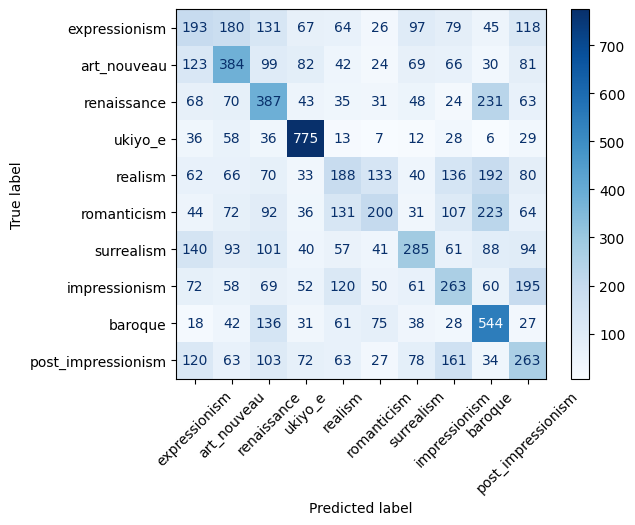

In [64]:
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=class_names, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot(xticks_rotation=45, cmap="Blues")

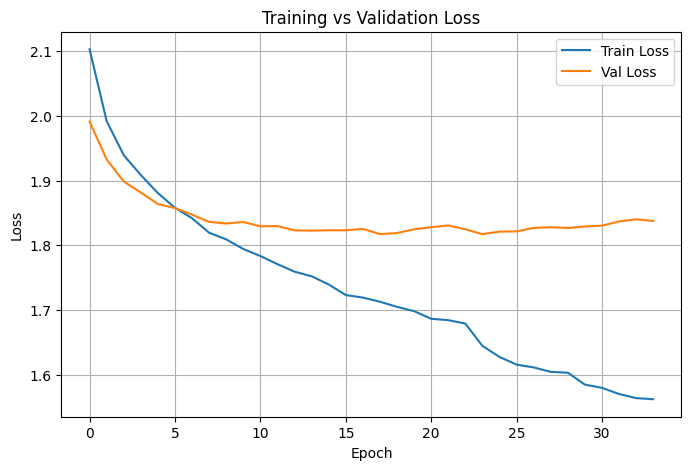

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

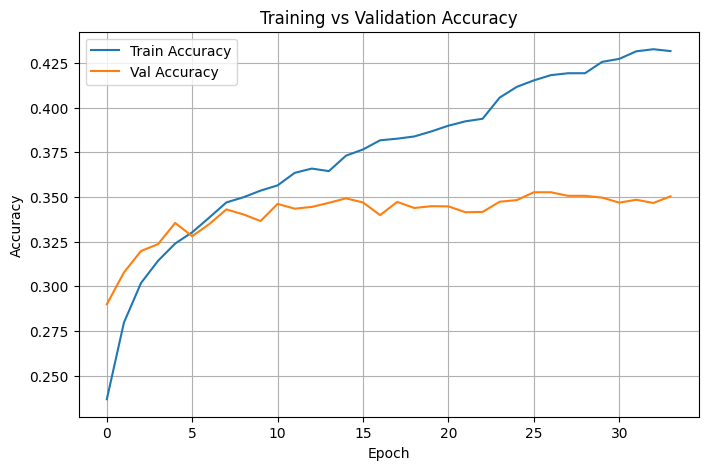

In [66]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [67]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])